 # Statsforecast based on top x crimes

In [16]:
from datetime import datetime

In [17]:
ROUND_PREDICTIONS = False
SAVE_MODEL_TO_DISK = True
SAVE_DICT_TO_DISK = True
CURRENT_DATE = datetime.now().strftime("%d%m%Y_%H%M")
print("CURRENT_DATE", CURRENT_DATE)

CURRENT_DATE 29112024_1649


## Imports

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import pickle
from sklearn.metrics import root_mean_squared_error
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic
from statsforecast.models import CrostonOptimized
from statsforecast.models import ADIDA
from statsforecast.models import SimpleExponentialSmoothingOptimized as SESOpt
from statsforecast.models import IMAPA
import numpy as np
from statsforecast.models import TSB

from scipy.stats import shapiro
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data

In [19]:
base_path = '..\\data\\top_10_crimes\\'

In [20]:
dist_ids = os.listdir(base_path)
dist_ids

['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']

In [21]:
cluster_names = os.listdir(os.path.join(base_path, dist_ids[0]))
print("num_cluster_names", len(cluster_names))

num_cluster_names 10


In [22]:
def load_crime_data(dist_id, offense, subset="train"):
    data_path = f"../data/top_10_crimes/{dist_id}/{offense}/{subset}.csv"
    crime_df = pd.read_csv(data_path, parse_dates=[0], index_col=0)
    return crime_df

In [23]:
crime_dist_dfs = {}
for i, dist_id in enumerate(dist_ids):
    crime_dist_dfs[dist_id] = {}
    for i, cluster_name in enumerate(cluster_names):
        train = load_crime_data(dist_id, cluster_name, subset="train")
        test = load_crime_data(dist_id, cluster_name, subset="test")
        
        # Save final dict
        crime_dist_dfs[dist_id][cluster_name] = {
            "train": train,
            "test": test
        }

In [24]:
print(f"districts in dict: {crime_dist_dfs.keys()}")
print(f"crimes in dict: {crime_dist_dfs["1.0"].keys()}")
print(f"test/train in dict: {crime_dist_dfs["1.0"]['Assault'].keys()}")

districts in dict: dict_keys(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0'])
crimes in dict: dict_keys(['Aggravated Assault', 'Assault', 'Auto Theft', 'Burglary', 'Domestic Assault', 'Domestic Violence', 'Property Damage', 'Sexual Assault', 'Shoplifting', 'Stolen Auto'])
test/train in dict: dict_keys(['train', 'test'])


In [25]:
crime_dist_dfs["1.0"]['Assault']["train"].head()

,Crime_Count
Reported_Date,
2015-01-05,5
2015-01-06,0
2015-01-07,0
2015-01-08,0
2015-01-09,0


### Prepare data for StatsForecast model

In [26]:
# Function to restructure the data
def restructure_for_forecasting(crime_dict):
    unique_id = 1
    for dist_id, crime_data in crime_dict.items():
        for cluster_name, df_types in crime_data.items():
            for df_type, df in df_types.items():
                # Reset index to make Reported_Date a column
                df = df.reset_index(names="Reported_Date")
                # Add unique_id column
                df['unique_id'] = unique_id
                # Rename columns
                df = df.rename(columns={"Reported_Date": "ds", "Crime_Count": "y"})
                # Ensure the date column is in datetime format
                df['ds'] = pd.to_datetime(df['ds'])
                # Reassign the processed dataframe back
                crime_dist_dfs[dist_id][cluster_name][df_type] = df
                unique_id+=1

# Apply the function
restructure_for_forecasting(crime_dist_dfs)

In [27]:
crime_dist_dfs["1.0"]['Assault']["train"].head()

,ds,y,unique_id
0,2015-01-05,5,3
1,2015-01-06,0,3
2,2015-01-07,0,3
3,2015-01-08,0,3
4,2015-01-09,0,3


In [28]:
crime_dist_dfs["1.0"]['Assault']["train"].dtypes

ds           datetime64[ns]
y                     int64
unique_id             int64
dtype: object

### Testing different models

In [29]:
def test_adf_stationary(data):
    result = adfuller(data)

    if result[1] > 0.05:
        return False
    else:
        return True

In [30]:
if SAVE_MODEL_TO_DISK:
    os.makedirs("sf_models_statsforecast", exist_ok=True)
    print("Created sf_models_statsforecast directory..")

# Loop through each district and crime category
for dist_id, crimes in crime_dist_dfs.items():
    for cluster_name, data_splits in tqdm.tqdm(crimes.items(), desc=f"dist {dist_id} Crimes", leave=False):
        train_data = data_splits["train"]
        test_data = data_splits["test"]
        
        try:
            # Prepare dict so store model config/results
            crime_dist_dfs[dist_id][cluster_name]["model_config"] = {}

            # Check if stationary
            #is_stationary = test_adf_stationary(train_data["y"])
            
            season_length = 7  # weekly trend
            horizon = len(test_data) # number of predictions
            
            models = [AutoARIMA(season_length=season_length), CrostonOptimized(), ADIDA(), IMAPA(), TSB(0.2, 0.2), SESOpt()]

            sf = StatsForecast(models=models, freq='D', n_jobs=-1)
                        
            sf.fit(df=train_data)

            # Save model to disk
            if SAVE_MODEL_TO_DISK:
                model_store_path = os.path.join("sf_models_statsforecast", str(dist_id), cluster_name)
                os.makedirs(model_store_path, exist_ok=True)
                print(f"Created: {model_store_path} directory..")
                # Serialize with Pickle
                with open(os.path.join(model_store_path, 'sf_model.pkl'), 'wb') as pkl:
                    pickle.dump(sf, pkl)

            # Generate predictions by doing cross validation
            d_cv_df = sf.cross_validation(
                df=test_data,
                h=1, # Horizon is 1, since we forecast the next day
                step_size=1, # Move the window by 1 time step
                n_windows=len(test_data)-1
            )

            crime_dist_dfs[dist_id][cluster_name]["predictions_df"] = d_cv_df

            # Calculate RMSE if test data is available
            if len(test_data) > 0:
                rmse_arima = root_mean_squared_error(d_cv_df['y'], d_cv_df['AutoARIMA'])
                rmse_croston = root_mean_squared_error(d_cv_df['y'], d_cv_df['CrostonOptimized'])
                rmse_adida = root_mean_squared_error(d_cv_df['y'], d_cv_df['ADIDA'])
                rmse_tsb = root_mean_squared_error(d_cv_df['y'], d_cv_df['TSB'])
                rmse_ses = root_mean_squared_error(d_cv_df['y'], d_cv_df['SESOpt'])
                
                # Create a dictionary to store RMSE values
                rmse_scores = {
                    'ARIMA': rmse_arima,
                    'CrostonOptimized': rmse_croston,
                    'ADIDA': rmse_adida,
                    'TSB': rmse_tsb,
                    'SESOpt': rmse_ses
                }

                # Find the model with the lowest RMSE
                best_model = min(rmse_scores, key=rmse_scores.get)
                best_rmse = rmse_scores[best_model]
                
                crime_dist_dfs[dist_id][cluster_name]["model_config"]["best_model"] = best_model
                crime_dist_dfs[dist_id][cluster_name]["model_config"]["best_rmse"] = best_rmse
                crime_dist_dfs[dist_id][cluster_name]["model_config"]["rmse_scores"] = rmse_scores
            else:
                crime_dist_dfs[dist_id][cluster_name]["model_config"]["best_model"] = None
                crime_dist_dfs[dist_id][cluster_name]["model_config"]["best_rmse"] = None
                crime_dist_dfs[dist_id][cluster_name]["model_config"]["rmse_scores"] = None
        
        except Exception as e:
            print(f"Failed for district {dist_id}, crime {cluster_name} with error: {e}")

Created Arima_models_statsforecast directory..


dist 1.0 Crimes:   0%|          | 0/10 [00:00<?, ?it/s]

Created: sf_models_statsforecast\1.0\Aggravated Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 1.0 Crimes:  10%|█         | 1/10 [03:58<35:43, 238.18s/it]

Created: sf_models_statsforecast\1.0\Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 1.0 Crimes:  20%|██        | 2/10 [06:11<23:31, 176.40s/it]

Created: sf_models_statsforecast\1.0\Auto Theft directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:1079: RuntimeWarning: divide by zero encountered in scalar divide
  tmp["aicc"] = tmp["aic"] + 2 * npar * (nstar / (nstar - npar - 1) - 1)
c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 1.0 Crimes:  30%|███       | 3/10 [15:33<41:09, 352.77s/it]

Created: sf_models_statsforecast\1.0\Burglary directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 1.0 Crimes:  40%|████      | 4/10 [18:38<28:36, 286.15s/it]

Created: sf_models_statsforecast\1.0\Domestic Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 1.0 Crimes:  50%|█████     | 5/10 [20:51<19:16, 231.21s/it]

Created: sf_models_statsforecast\1.0\Domestic Violence directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:1079: RuntimeWarning: divide by zero encountered in scalar divide
  tmp["aicc"] = tmp["aic"] + 2 * npar * (nstar / (nstar - npar - 1) - 1)
c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 1.0 Crimes:  60%|██████    | 6/10 [22:39<12:37, 189.32s/it]

Created: sf_models_statsforecast\1.0\Property Damage directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 1.0 Crimes:  70%|███████   | 7/10 [24:45<08:25, 168.54s/it]

Created: sf_models_statsforecast\1.0\Sexual Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 1.0 Crimes:  80%|████████  | 8/10 [31:56<08:24, 252.03s/it]

Created: sf_models_statsforecast\1.0\Shoplifting directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 1.0 Crimes:  90%|█████████ | 9/10 [35:23<03:58, 238.07s/it]

Created: sf_models_statsforecast\1.0\Stolen Auto directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 2.0 Crimes:   0%|          | 0/10 [00:00<?, ?it/s]          

Created: sf_models_statsforecast\2.0\Aggravated Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 2.0 Crimes:  10%|█         | 1/10 [02:16<20:24, 136.06s/it]

Created: sf_models_statsforecast\2.0\Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 2.0 Crimes:  20%|██        | 2/10 [10:40<47:00, 352.52s/it]

Created: sf_models_statsforecast\2.0\Auto Theft directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:1079: RuntimeWarning: divide by zero encountered in scalar divide
  tmp["aicc"] = tmp["aic"] + 2 * npar * (nstar / (nstar - npar - 1) - 1)
dist 2.0 Crimes:  30%|███       | 3/10 [18:20<46:51, 401.65s/it]

Created: sf_models_statsforecast\2.0\Burglary directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 2.0 Crimes:  40%|████      | 4/10 [20:55<30:26, 304.43s/it]

Created: sf_models_statsforecast\2.0\Domestic Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:1079: RuntimeWarning: divide by zero encountered in scalar divide
  tmp["aicc"] = tmp["aic"] + 2 * npar * (nstar / (nstar - npar - 1) - 1)
dist 2.0 Crimes:  50%|█████     | 5/10 [23:05<20:06, 241.35s/it]

Created: sf_models_statsforecast\2.0\Domestic Violence directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 2.0 Crimes:  60%|██████    | 6/10 [25:27<13:50, 207.58s/it]

Created: sf_models_statsforecast\2.0\Property Damage directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 2.0 Crimes:  70%|███████   | 7/10 [34:10<15:32, 310.67s/it]

Created: sf_models_statsforecast\2.0\Sexual Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 2.0 Crimes:  80%|████████  | 8/10 [38:08<09:35, 287.52s/it]

Created: sf_models_statsforecast\2.0\Shoplifting directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 2.0 Crimes:  90%|█████████ | 9/10 [40:28<04:01, 241.60s/it]

Created: sf_models_statsforecast\2.0\Stolen Auto directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 3.0 Crimes:   0%|          | 0/10 [00:00<?, ?it/s]          

Created: sf_models_statsforecast\3.0\Aggravated Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 3.0 Crimes:  10%|█         | 1/10 [04:04<36:41, 244.64s/it]

Created: sf_models_statsforecast\3.0\Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:1079: RuntimeWarning: divide by zero encountered in scalar divide
  tmp["aicc"] = tmp["aic"] + 2 * npar * (nstar / (nstar - npar - 1) - 1)
c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 3.0 Crimes:  20%|██        | 2/10 [16:22<1:11:17, 534.65s/it]

Created: sf_models_statsforecast\3.0\Auto Theft directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 3.0 Crimes:  30%|███       | 3/10 [18:17<40:02, 343.19s/it]  

Created: sf_models_statsforecast\3.0\Burglary directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 3.0 Crimes:  40%|████      | 4/10 [21:20<27:58, 279.71s/it]

Created: sf_models_statsforecast\3.0\Domestic Assault directory..


dist 3.0 Crimes:  50%|█████     | 5/10 [23:12<18:17, 219.48s/it]

Created: sf_models_statsforecast\3.0\Domestic Violence directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 3.0 Crimes:  60%|██████    | 6/10 [26:12<13:43, 205.82s/it]

Created: sf_models_statsforecast\3.0\Property Damage directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:1079: RuntimeWarning: divide by zero encountered in scalar divide
  tmp["aicc"] = tmp["aic"] + 2 * npar * (nstar / (nstar - npar - 1) - 1)
c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 3.0 Crimes:  70%|███████   | 7/10 [28:46<09:26, 188.92s/it]

Created: sf_models_statsforecast\3.0\Sexual Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 3.0 Crimes:  80%|████████  | 8/10 [35:25<08:32, 256.04s/it]

Created: sf_models_statsforecast\3.0\Shoplifting directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 3.0 Crimes:  90%|█████████ | 9/10 [39:51<04:19, 259.05s/it]

Created: sf_models_statsforecast\3.0\Stolen Auto directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 4.0 Crimes:   0%|          | 0/10 [00:00<?, ?it/s]          

Created: sf_models_statsforecast\4.0\Aggravated Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 4.0 Crimes:  10%|█         | 1/10 [04:16<38:32, 256.98s/it]

Created: sf_models_statsforecast\4.0\Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 4.0 Crimes:  20%|██        | 2/10 [08:00<31:38, 237.27s/it]

Created: sf_models_statsforecast\4.0\Auto Theft directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 4.0 Crimes:  30%|███       | 3/10 [10:42<23:41, 203.12s/it]

Created: sf_models_statsforecast\4.0\Burglary directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 4.0 Crimes:  40%|████      | 4/10 [13:51<19:44, 197.41s/it]

Created: sf_models_statsforecast\4.0\Domestic Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 4.0 Crimes:  50%|█████     | 5/10 [21:51<24:55, 299.18s/it]

Created: sf_models_statsforecast\4.0\Domestic Violence directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 4.0 Crimes:  60%|██████    | 6/10 [25:13<17:45, 266.28s/it]

Created: sf_models_statsforecast\4.0\Property Damage directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 4.0 Crimes:  70%|███████   | 7/10 [27:35<11:17, 225.70s/it]

Created: sf_models_statsforecast\4.0\Sexual Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 4.0 Crimes:  80%|████████  | 8/10 [29:28<06:19, 189.73s/it]

Created: sf_models_statsforecast\4.0\Shoplifting directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 4.0 Crimes:  90%|█████████ | 9/10 [31:59<02:57, 177.76s/it]

Created: sf_models_statsforecast\4.0\Stolen Auto directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 5.0 Crimes:   0%|          | 0/10 [00:00<?, ?it/s]          

Created: sf_models_statsforecast\5.0\Aggravated Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 5.0 Crimes:  10%|█         | 1/10 [02:40<24:06, 160.68s/it]

Created: sf_models_statsforecast\5.0\Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:1079: RuntimeWarning: divide by zero encountered in scalar divide
  tmp["aicc"] = tmp["aic"] + 2 * npar * (nstar / (nstar - npar - 1) - 1)
c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 5.0 Crimes:  20%|██        | 2/10 [05:18<21:10, 158.77s/it]

Created: sf_models_statsforecast\5.0\Auto Theft directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 5.0 Crimes:  30%|███       | 3/10 [08:11<19:19, 165.66s/it]

Created: sf_models_statsforecast\5.0\Burglary directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 5.0 Crimes:  40%|████      | 4/10 [11:46<18:29, 184.97s/it]

Created: sf_models_statsforecast\5.0\Domestic Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 5.0 Crimes:  50%|█████     | 5/10 [15:45<17:03, 204.60s/it]

Created: sf_models_statsforecast\5.0\Domestic Violence directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 5.0 Crimes:  60%|██████    | 6/10 [17:51<11:51, 177.83s/it]

Created: sf_models_statsforecast\5.0\Property Damage directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 5.0 Crimes:  70%|███████   | 7/10 [20:09<08:13, 164.61s/it]

Created: sf_models_statsforecast\5.0\Sexual Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:1079: RuntimeWarning: divide by zero encountered in scalar divide
  tmp["aicc"] = tmp["aic"] + 2 * npar * (nstar / (nstar - npar - 1) - 1)
c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 5.0 Crimes:  80%|████████  | 8/10 [23:29<05:52, 176.00s/it]

Created: sf_models_statsforecast\5.0\Shoplifting directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 5.0 Crimes:  90%|█████████ | 9/10 [25:58<02:47, 167.61s/it]

Created: sf_models_statsforecast\5.0\Stolen Auto directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 6.0 Crimes:   0%|          | 0/10 [00:00<?, ?it/s]          

Created: sf_models_statsforecast\6.0\Aggravated Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 6.0 Crimes:  10%|█         | 1/10 [02:22<21:18, 142.05s/it]

Created: sf_models_statsforecast\6.0\Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 6.0 Crimes:  20%|██        | 2/10 [04:25<17:26, 130.87s/it]

Created: sf_models_statsforecast\6.0\Auto Theft directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:213: RuntimeWarning: divide by zero encountered in scalar divide
  mod["Pn"][0, 0] = 1 / (1 - phi[0] ** 2) if p > 0 else 1
c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 6.0 Crimes:  30%|███       | 3/10 [09:32<24:39, 211.34s/it]

Created: sf_models_statsforecast\6.0\Burglary directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 6.0 Crimes:  40%|████      | 4/10 [11:16<16:55, 169.27s/it]

Created: sf_models_statsforecast\6.0\Domestic Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 6.0 Crimes:  50%|█████     | 5/10 [14:39<15:06, 181.30s/it]

Created: sf_models_statsforecast\6.0\Domestic Violence directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 6.0 Crimes:  60%|██████    | 6/10 [16:40<10:42, 160.73s/it]

Created: sf_models_statsforecast\6.0\Property Damage directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 6.0 Crimes:  70%|███████   | 7/10 [22:28<11:05, 221.96s/it]

Created: sf_models_statsforecast\6.0\Sexual Assault directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
dist 6.0 Crimes:  80%|████████  | 8/10 [26:53<07:51, 235.68s/it]

Created: sf_models_statsforecast\6.0\Shoplifting directory..


dist 6.0 Crimes:  90%|█████████ | 9/10 [31:53<04:15, 255.75s/it]

Created: sf_models_statsforecast\6.0\Stolen Auto directory..


c:\Users\leand\anaconda3\envs\ts_cds122\Lib\site-packages\statsforecast\arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)


#### Plotting

In [31]:
def plot_rmse_heatmap(crime_dist_dfs):
    """
    Function to create a heatmap plot of RMSE values for crimes across districts
    """
    # Initialize an empty dictionary to hold RMSE values
    rmse_data = {
        "District": [],
        "Crime": [],
        "RMSE": []
    }
    
    # Collect RMSE values for each crime in each district
    for dist_id, crimes in crime_dist_dfs.items():
        for crime_name, crime_info in crimes.items():
            if crime_info.get("model_config") and crime_info["model_config"].get("best_rmse") is not None:
                rmse_data["District"].append(dist_id)
                rmse_data["Crime"].append(crime_name)
                rmse_data["RMSE"].append(crime_info["model_config"]["best_rmse"])
    
    # Create a DataFrame from the collected RMSE data
    rmse_df = pd.DataFrame(rmse_data)
    rmse_pivot = rmse_df.pivot(index="Crime", columns="District", values="RMSE")
    
    # Plot the heatmap
    plt.figure(figsize=(8, 8))
    sns.heatmap(rmse_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'RMSE'})
    plt.title("RMSE of Crime Predictions by District and Crime Category")
    plt.xlabel("District")
    plt.ylabel("Crime Category")
    plt.tight_layout()
    plt.show()

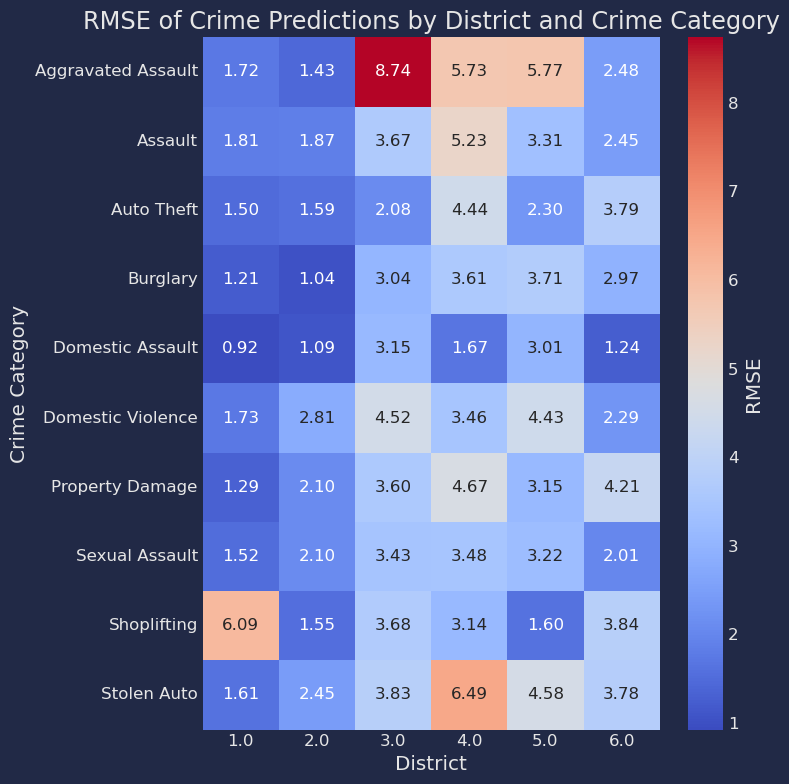

In [36]:
plot_rmse_heatmap(crime_dist_dfs)

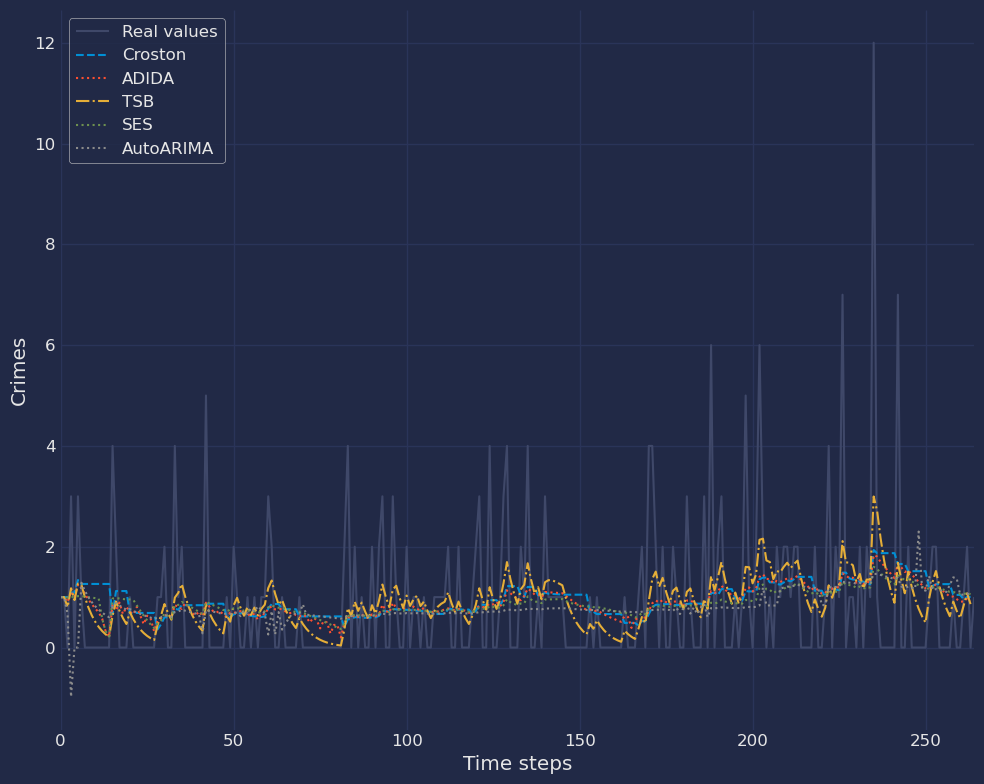

In [38]:
df_train = crime_dist_dfs["1.0"]['Auto Theft']["train"]
df_test = crime_dist_dfs["1.0"]['Auto Theft']["test"]
predictions = crime_dist_dfs["1.0"]['Auto Theft']["predictions_df"]

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df_test.index, df_test['y'], color='#3f4869', label='Real values')
ax.plot(predictions.index, predictions['CrostonOptimized'], ls='--', label='Croston')
ax.plot(predictions.index, predictions['ADIDA'], ls=':', label='ADIDA')
ax.plot(predictions.index, predictions['TSB'], ls='-.', label='TSB')
ax.plot(predictions.index, predictions['SESOpt'], ls=':', label='SES')
ax.plot(predictions.index, predictions['AutoARIMA'], ls=':', label='AutoARIMA')

ax.set_ylabel('Crimes')
ax.set_xlabel('Time steps')

ax.legend(loc='best')

plt.xlim([0,len(df_test)-1])

plt.tight_layout()

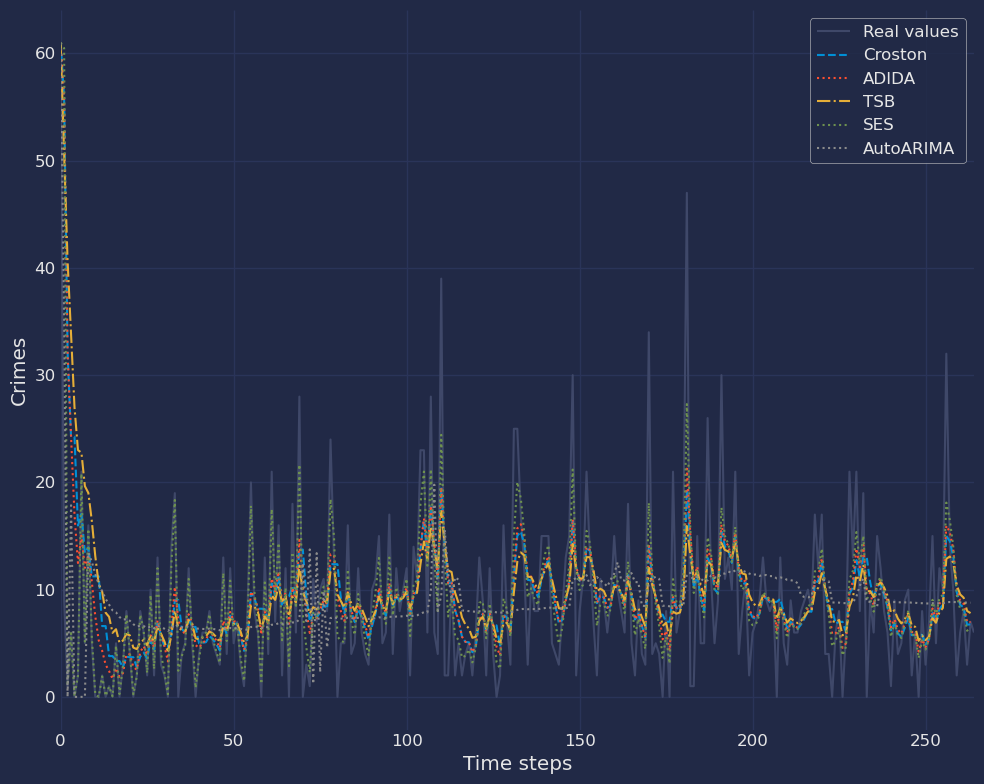

In [41]:
df_train = crime_dist_dfs["3.0"]['Aggravated Assault']["train"]
df_test = crime_dist_dfs["3.0"]['Aggravated Assault']["test"]
predictions = crime_dist_dfs["3.0"]['Aggravated Assault']["predictions_df"]

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df_test.index, df_test['y'], color='#3f4869', label='Real values')
ax.plot(predictions.index, predictions['CrostonOptimized'], ls='--', label='Croston')
ax.plot(predictions.index, predictions['ADIDA'], ls=':', label='ADIDA')
ax.plot(predictions.index, predictions['TSB'], ls='-.', label='TSB')
ax.plot(predictions.index, predictions['SESOpt'], ls=':', label='SES')
ax.plot(predictions.index, predictions['AutoARIMA'], ls=':', label='AutoARIMA')

ax.set_ylabel('Crimes')
ax.set_xlabel('Time steps')

ax.legend(loc='best')

plt.xlim([0,len(df_test)-1])

plt.tight_layout()

In [34]:
if SAVE_DICT_TO_DISK:
    # Save dictionary to a pickle file
    with open(f"..\\data\\mergedData\\statsforecast_crime_dist_dfs_top_10_{CURRENT_DATE}.pkl", 'wb') as file:
        pickle.dump(crime_dist_dfs, file)

In [35]:
# Load dictionary from a pickle file
#with open(f"..\\data\\mergedData\\crime_dist_dfs_top_{TOP_X_CRIMES}.pkl", 'rb') as file:
#    crime_dist_dfs = pickle.load(file)

---